In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.affinity import scale
from shapely.geometry import Point, Polygon
import plotly.express as px
import matplotlib.pyplot as plt
from pandas import DataFrame as DF
from scipy.stats import skew
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import seaborn as sns


sns.set(rc={'figure.figsize':(11.7,8.27)})


metadata_df = pd.read_csv("../sis_dataset/sis_dataset/full_sample_metadata.csv")


fig = px.scatter_geo(metadata_df, lat='Latitude',lon='Longitude', hover_name="id")
fig.update_layout(title = 'World map', title_x=0.5)
fig.show()

/home/bart2/.pyenv/versions/3.9.5/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


<AxesSubplot:>

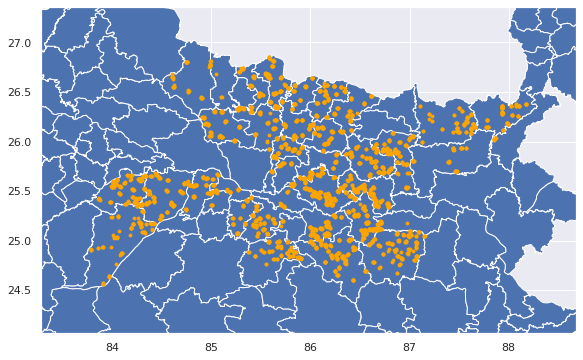

In [2]:
sample_points = [Point(xy) for xy in zip(metadata_df['Longitude'], metadata_df['Latitude'])]
sample_points_gdf = gpd.GeoDataFrame(metadata_df, geometry=sample_points)   


india = gpd.read_file("india/IND_adm3.shp")

ax = india.plot(figsize=(10, 6))


minx, miny, maxx, maxy = gpd.GeoSeries(sample_points).total_bounds
margin = 0.5
ax.set_xlim(minx - margin, maxx + margin)
ax.set_ylim(miny - margin, maxy + margin)


sample_points_gdf.plot(ax=ax, marker='o', color='orange', markersize=8)

<AxesSubplot:>

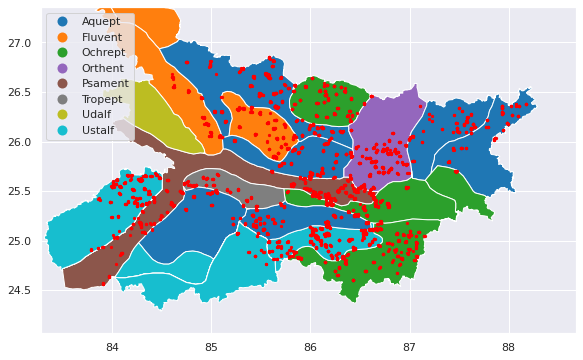

In [3]:
soil_types_gdf = gpd.read_file("bihar_soil_types/bihar_soil_types.shp")
soil_types_gdf = soil_types_gdf.iloc[1:] # first row is the entire region


ax = soil_types_gdf.plot(soil_types_gdf["soil_type"], figsize=(10, 6), label="soil_type", legend=True)
minx, miny, maxx, maxy = gpd.GeoSeries(sample_points).total_bounds
margin = 0.5
ax.set_xlim(minx - margin, maxx + margin)
ax.set_ylim(miny - margin, maxy + margin)


sample_points_gdf.plot(ax=ax, marker='o', color='red', markersize=5, legend=True)


0

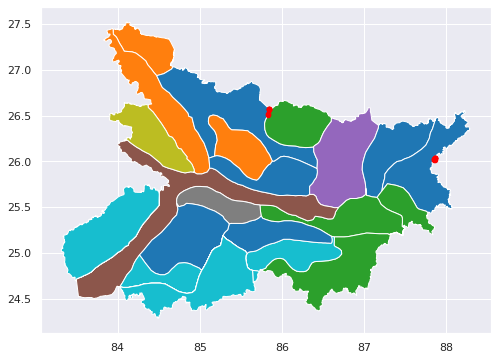

In [4]:

sample_points_gdf = sample_points_gdf.set_crs('epsg:4326') # set coordinate system for the join

dfsjoin = gpd.sjoin(sample_points_gdf, soil_types_gdf, how="left") # Spatial join Points to polygons

unmatched_index = dfsjoin['index_right'].isna() # points that didn't match any region


ax = soil_types_gdf.plot(soil_types_gdf["soil_type"], figsize=(10, 6))
sample_points_gdf[unmatched_index].plot(ax=ax, marker='o', color='red', markersize=20)


# scale them to the centroid of all samples
centroid = Polygon(sample_points).centroid
scale_factor = 0.983
scale_to_centroid = lambda p: scale(p, xfact=scale_factor, yfact=scale_factor, origin=centroid)

sample_points_scaled_gdf = sample_points_gdf.copy()
sample_points_scaled_gdf.loc[unmatched_index, "geometry"] = sample_points_gdf.loc[unmatched_index, "geometry"].apply(scale_to_centroid)

dfsjoin_scaled = gpd.sjoin(sample_points_scaled_gdf, soil_types_gdf, how="left")
dfsjoin_scaled['index_right'].isna().sum() # == 0 with scale factor 0.985

In [5]:
dfpivot = pd.pivot_table(dfsjoin_scaled, index="soil_type", aggfunc={"id": "count"})
assert dfpivot.sum().item() == len(sample_points_gdf)

dfpivot


id
soil_type      
Aquept     1020
Fluvent     232
Ochrept     584
Orthent     290
Psament     340
Tropept     107
Ustalf      610

In [6]:
# remove outliers first
##visualize before outliers removal
###box plots
### histograms
### pca to see outliers
## what kind of outlier removal do we need? one can be an improper measurement of a
## particular nutrient, but something completely else is an outlier in the high dimensional space - an odd soil sample.
## do we want to clip or turn to np.nan or drop? how to treat nans afterwards?

# compare unsupervised clustering with soil types
# maybe first dry chem on sis
# EDA on US data
# towards stratification
# correlations

# apply transforms to skewed variables


dropped 683 rows
dropped 196 rows
dropped 247 rows
dropped 195 rows
dropped 192 rows
dropped 193 rows
dropped 192 rows
dropped 195 rows
dropped 197 rows
dropped 192 rows
dropped 193 rows
dropped 195 rows
dropped 192 rows
dropped 683 rows


<AxesSubplot:>

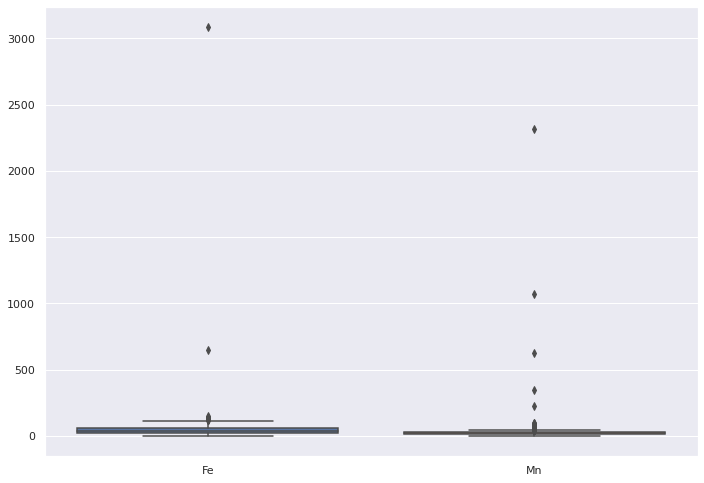

In [2]:

def assert_unreachable(x):
    raise AssertionError(f"Entered a code path that should not be reachable, argument value: {x!r}")

def normalize(df):
    return (df - df.mean()) / df.std()

def unskew(s, threshold=1.5):
    eps = 1e-5
    while skew(s) >= threshold:
        s = s - min(s)
        s = np.log(1 + s)
    return s

def detect_outliers(df_or_s, method="quantile", quantile=0.97, std_mult=3):
    if method == "quantile":
        upper = df_or_s.quantile(quantile)
        lower = df_or_s.quantile(1 - quantile)
        outliers = (df_or_s >= upper) | (df_or_s <= lower)
    elif method == "std":
        outliers = (df_or_s - df_or_s.mean()).abs() >= std_mult * df_or_s.std()
    else:
        assert_unreachable(method)
    return outliers


def drop_outliers(df_or_s, method="quantile",quantile=0.97, std_mult=3):
    df_or_s = df_or_s.copy()
    len_before = len(df_or_s.index)
    outliers = detect_outliers(df_or_s, method, quantile, std_mult)
    if isinstance(df_or_s, DF):
        outliers = outliers.any(axis=1)
    df_or_s = df_or_s[~outliers]
    len_after = len(df_or_s.index)
    print(f"dropped {len_before - len_after} rows")
    return df_or_s
            

        
def drop_outliers_col(df, col, method="quantile", quantile=0.97, std_mult=3):
    outliers = detect_outliers(df[col], method, quantile, std_mult)
    print(f"dropped {outliers.sum()} outliers")
    return df[~outliers]

wcdf_raw = pd.read_csv('../sis_dataset/sis_dataset/wetchem.csv')


def clean_wcdf(wcdf_raw):
    wcdf_values = wcdf_raw.iloc[:,1:]
    wcdf_unskewed = wcdf_values.apply(unskew)
    wcdf_norm = normalize(wcdf_unskewed)
    wcdf = drop_outliers(wcdf_norm, method="quantile", quantile=0.99)
    return wcdf

wcdf_values = wcdf_raw.iloc[:,1:]
wcdf_unskewed = wcdf_values.apply(unskew)
wcdf_norm = normalize(wcdf_unskewed)
wcdf = drop_outliers(wcdf_norm, method="quantile", quantile=0.99)

def get_clean_wcdf():
    wcdf_raw = pd.read_csv('../sis_dataset/sis_dataset/wetchem.csv')
    return clean_wcdf(wcdf_raw)

wcdf_cols = [drop_outliers(wcdf_norm[col]) for col in wcdf_norm]
wcdf = clean_wcdf(wcdf_raw)

# sns.set(rc={'figure.figsize':(4.7,8.27)})

sns.boxplot(data=wcdf_raw[["Fe", "Mn"]])
# sns.boxplot(data=wcdf_raw)


In [8]:
# nitrogen quantized

x = pd.Series(wcdf_raw.N.unique()).sort_values().reset_index(drop=True).values
diffs = x[1:] - x[:-1]
diffs = diffs[diffs > 1e-2]
set(diffs)


{12.535999999999518,
 12.537999999999471,
 12.537999999999485,
 12.5379999999995,
 12.539999999999452,
 12.539999999999466,
 12.539999999999537,
 12.53999999999968,
 12.539999999999907,
 12.539999999999992,
 12.541999999999291,
 12.541999999999646,
 12.543999999998732,
 12.54399999999876,
 12.543999999998846,
 12.543999999998903,
 12.543999999998931,
 12.543999999999073,
 12.54399999999913,
 12.543999999999293,
 12.5439999999993,
 12.543999999999414,
 12.543999999999585,
 12.543999999999755,
 12.543999999999812,
 12.543999999999926,
 12.544000000000011,
 12.54400000000011,
 50.176000000000045,
 75.26399999999956,
 75.26400000000058,
 112.8960000000003,
 175.61599999999964}

array([[ 0.16464577,  0.04947648,  0.14369259, ..., -0.05519634,
        -1.48458346, -0.53404667],
       [-0.51156744, -0.12660298,  0.40976381, ...,  0.63282852,
         0.34689297, -0.28918531],
       [-0.01567775, -0.4062774 , -0.4518386 , ..., -0.52052591,
         0.4275005 ,  0.64195582],
       ...,
       [ 1.04372295, -0.31087079, -0.01575484, ..., -0.78359492,
        -0.08511987,  0.19265503],
       [ 1.20150604, -0.60408047, -0.08752468, ..., -0.39911411,
         0.9542323 , -0.44495293],
       [ 1.43818066, -0.60408047, -0.30283421, ..., -0.42917116,
        -0.16635308,  0.19265503]])

/home/bart2/.pyenv/versions/3.9.5/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:>

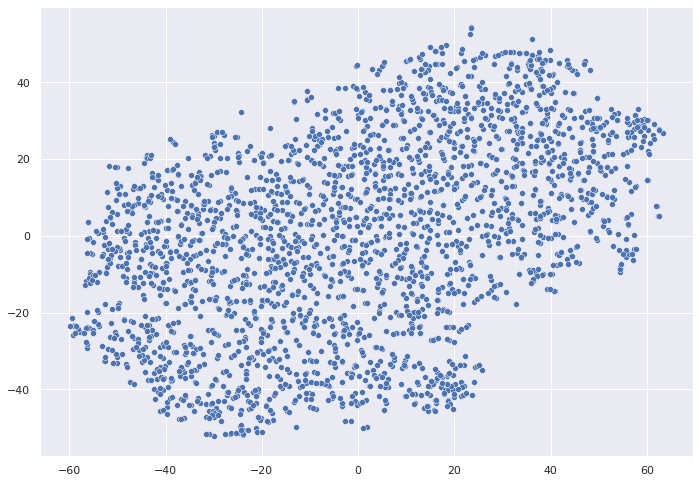

In [39]:
X_tsne = TSNE(n_components=2).fit_transform(wcdf)
sns.scatterplot(X_tsne[:,0], X_tsne[:,1])

<AxesSubplot:>

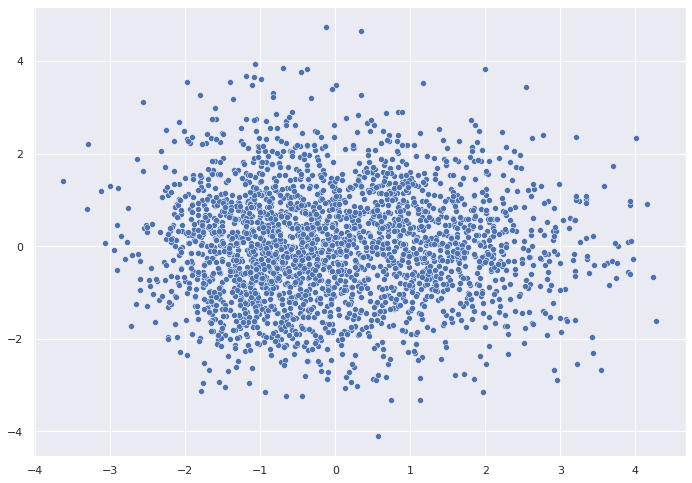

In [26]:
X_pca = PCA(n_components=2).fit_transform(wcdf)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1])

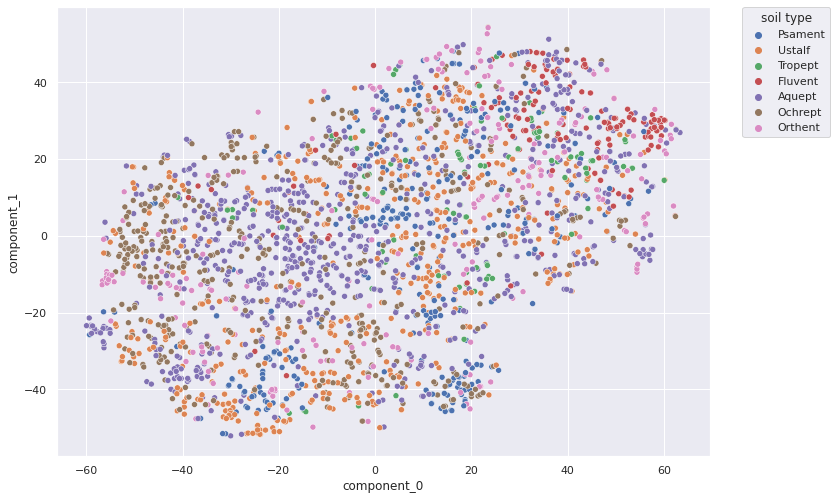

In [41]:
wcdf.join(dfsjoin_scaled)
embedded = DF(X_tsne, columns=["component_0", "component_1"])

embedded.index = wcdf.index
embedded_with_metadata = embedded.join(dfsjoin_scaled)

sns.scatterplot(data=embedded_with_metadata, x="component_0", y="component_1", hue="soil_type")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="soil type")


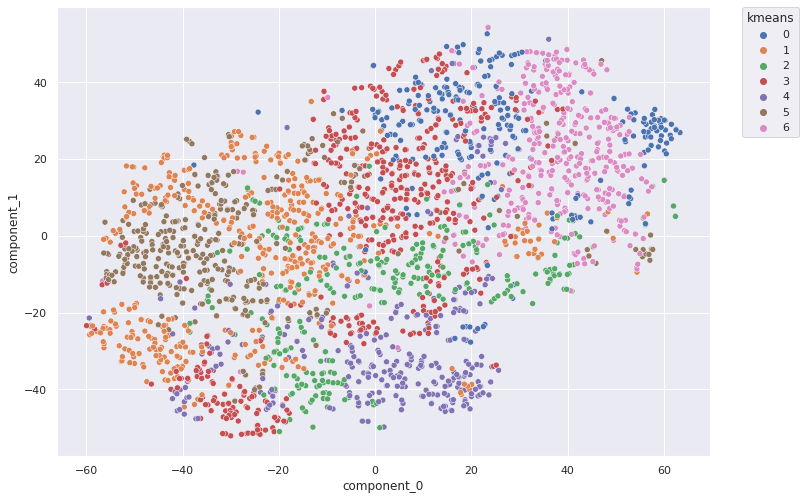

In [42]:
embedded["kmeans"] = KMeans(n_clusters=7).fit(wcdf[wcdf.columns[1:]]).labels_

sns.scatterplot(data=embedded, x="component_0", y="component_1", hue="kmeans", palette="deep")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="kmeans")


dropped 159 outliers
dropped 165 outliers
dropped 154 outliers
dropped 190 outliers
dropped 205 outliers
dropped 154 outliers
dropped 163 outliers
dropped 155 outliers
dropped 152 outliers
dropped 150 outliers
dropped 150 outliers
dropped 151 outliers


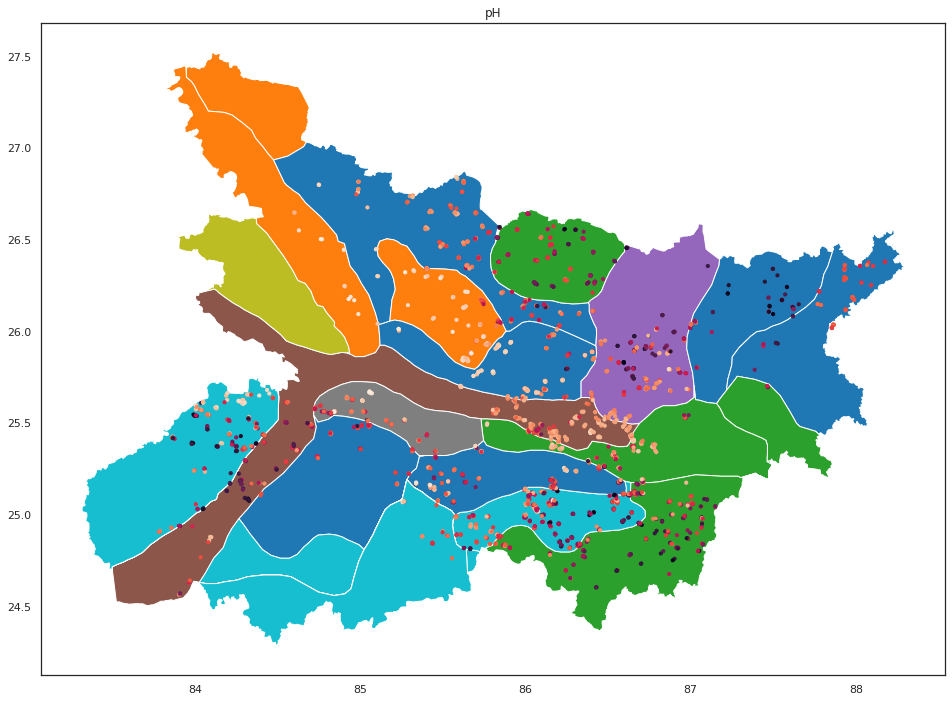

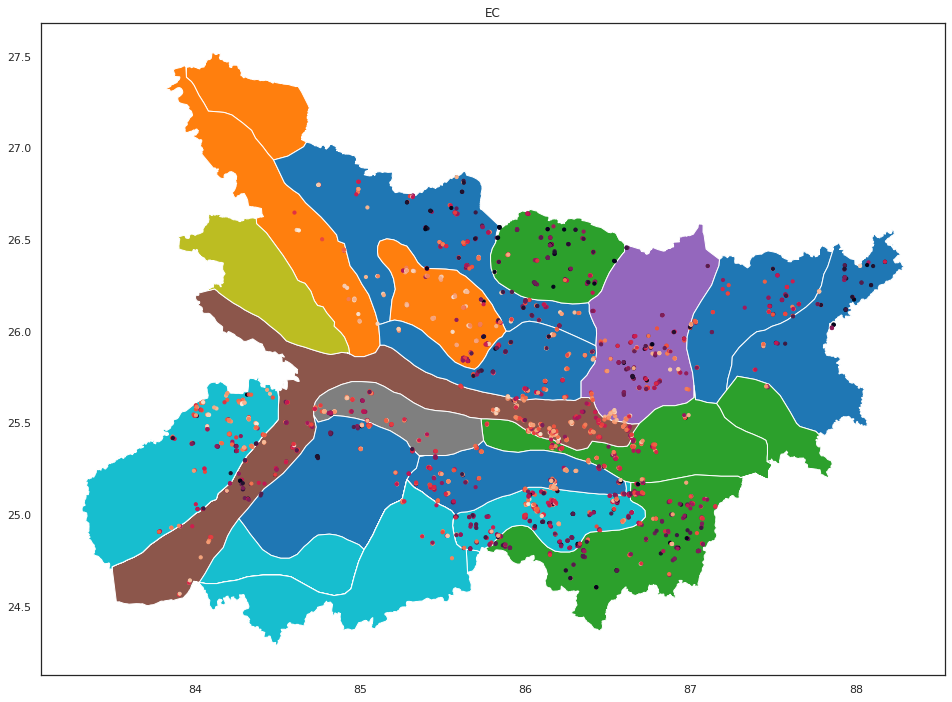

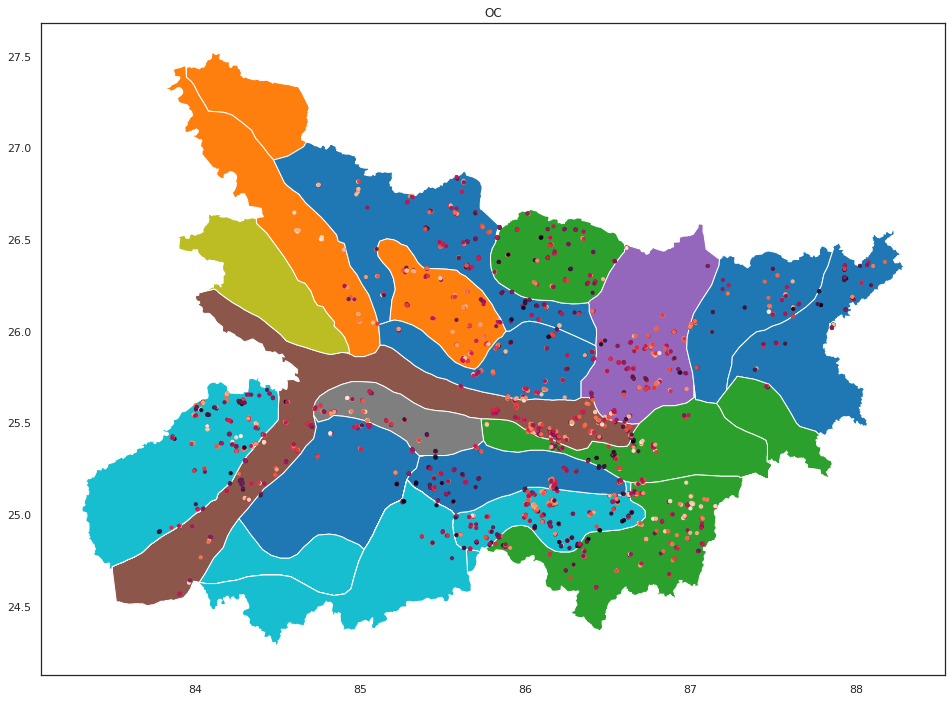

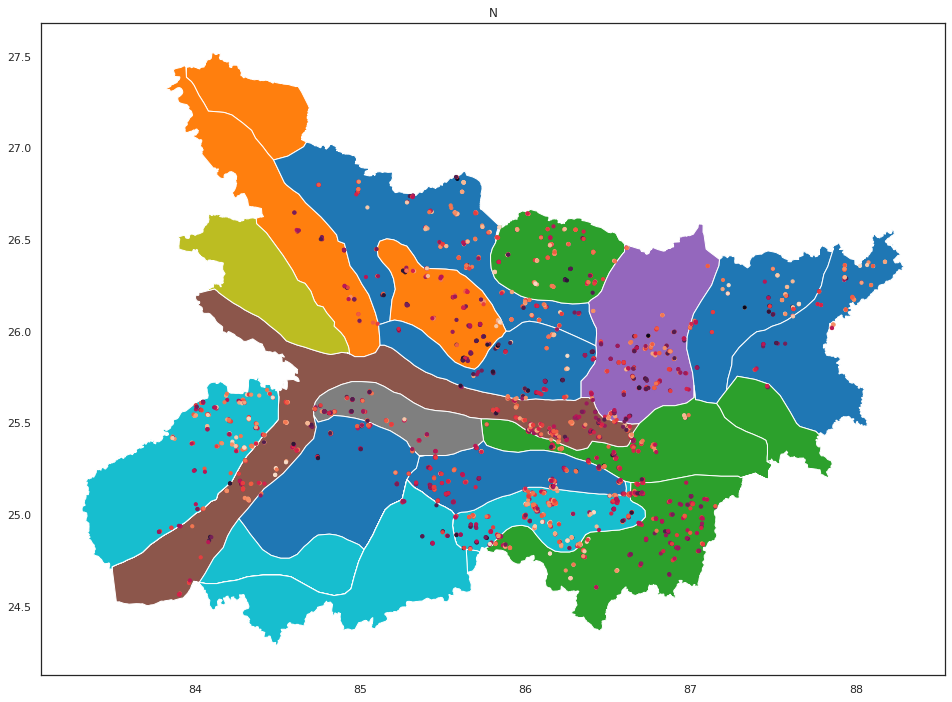

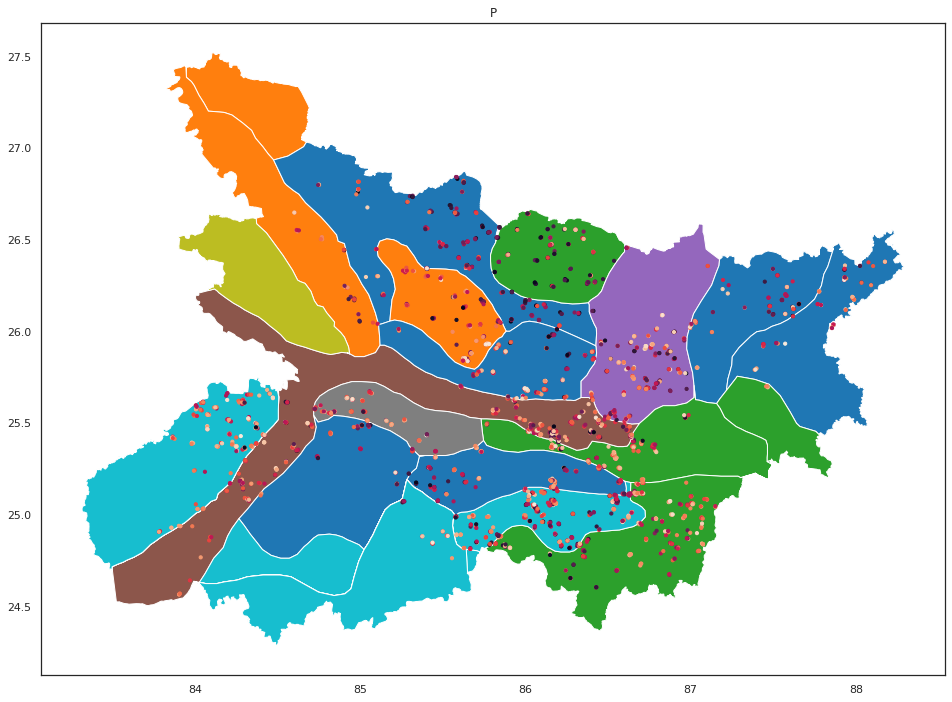

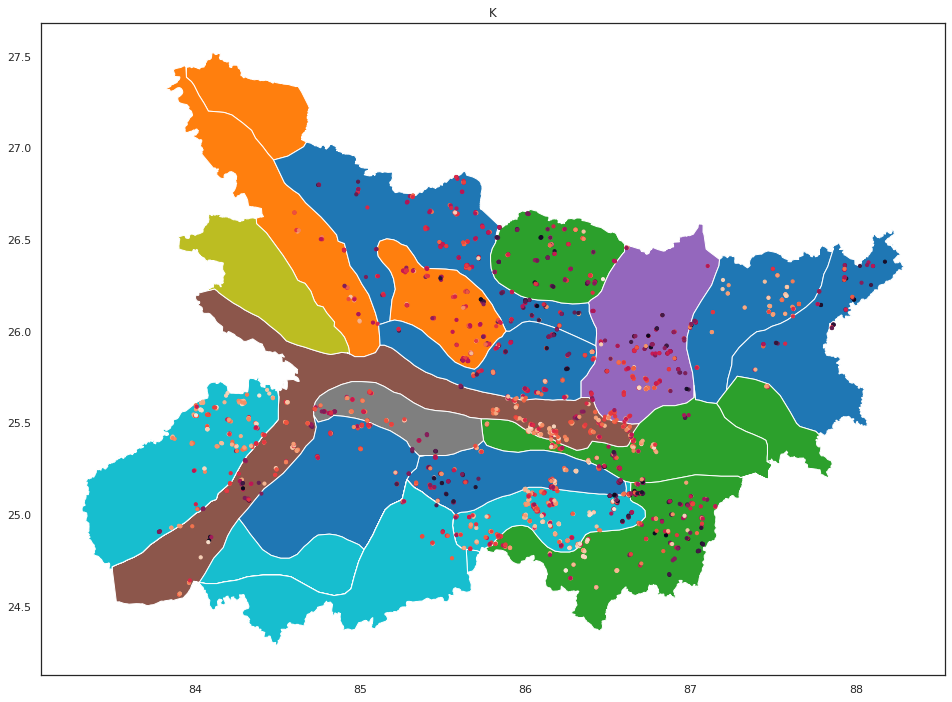

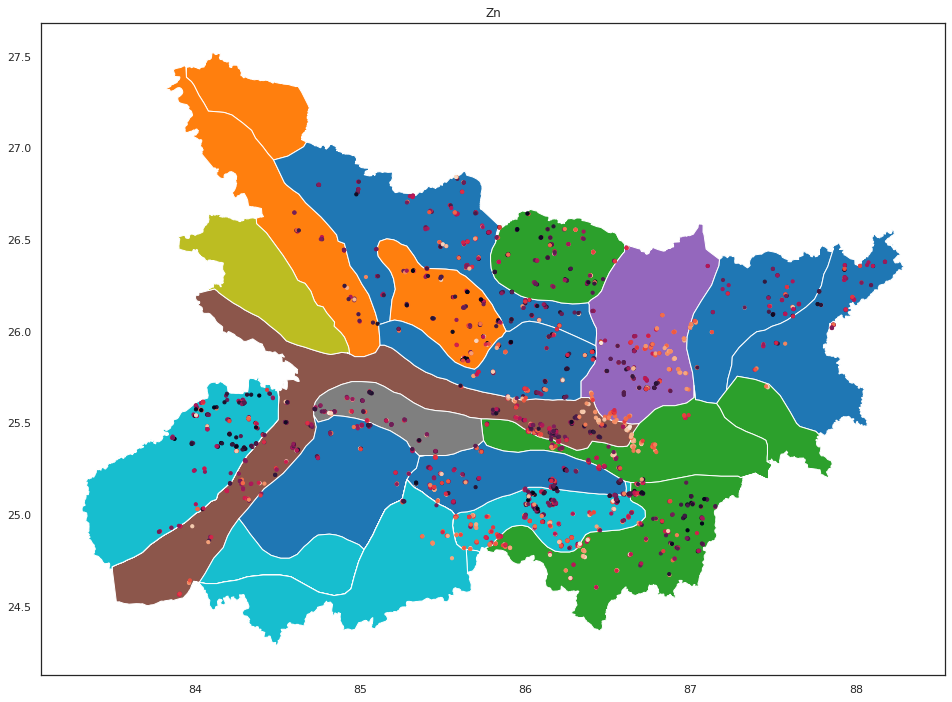

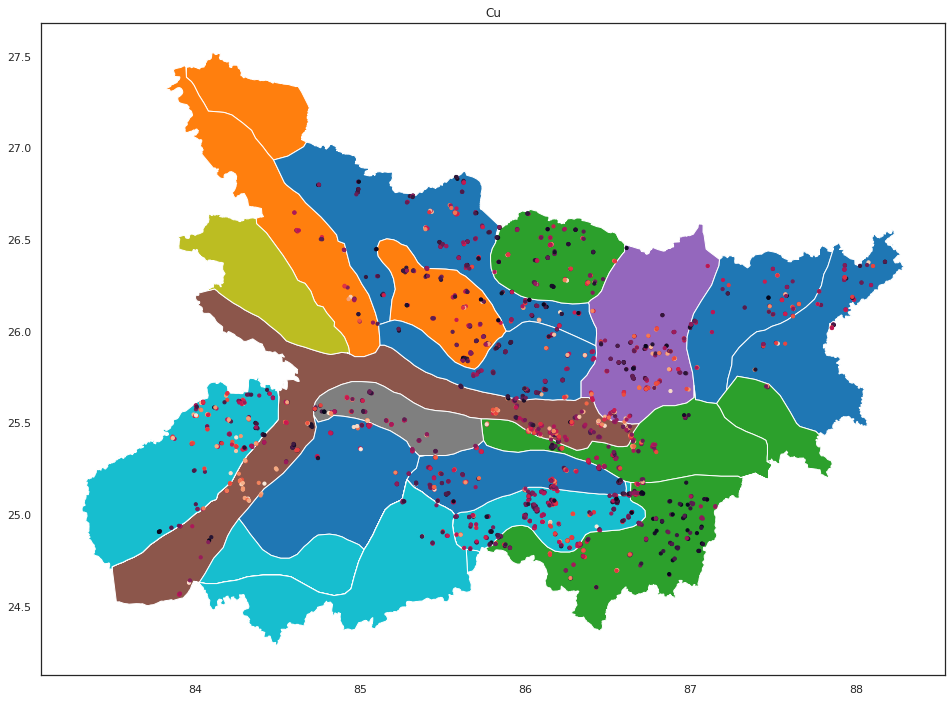

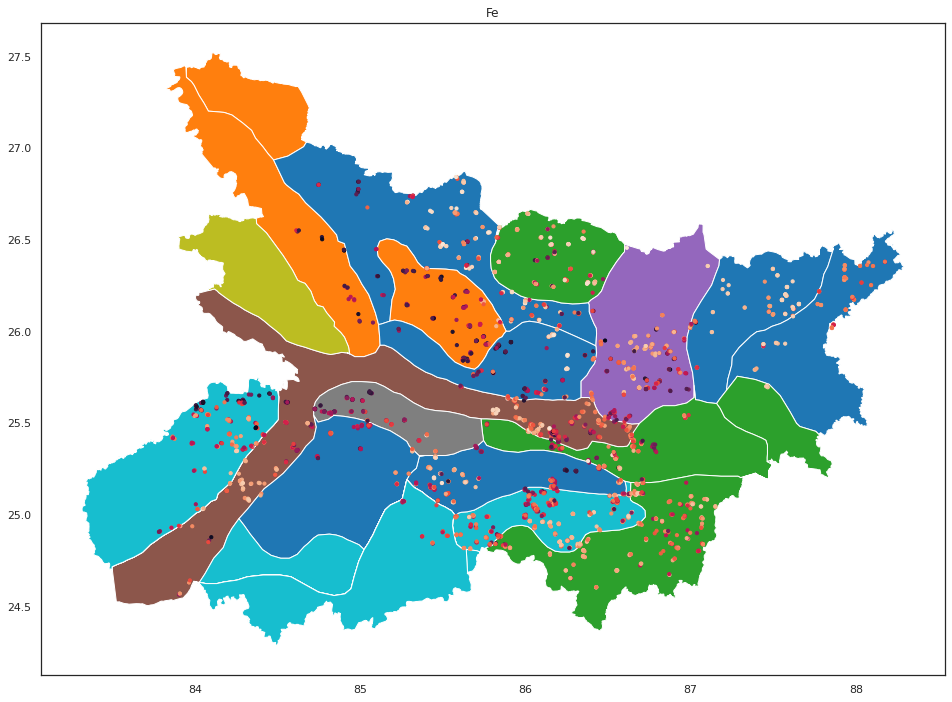

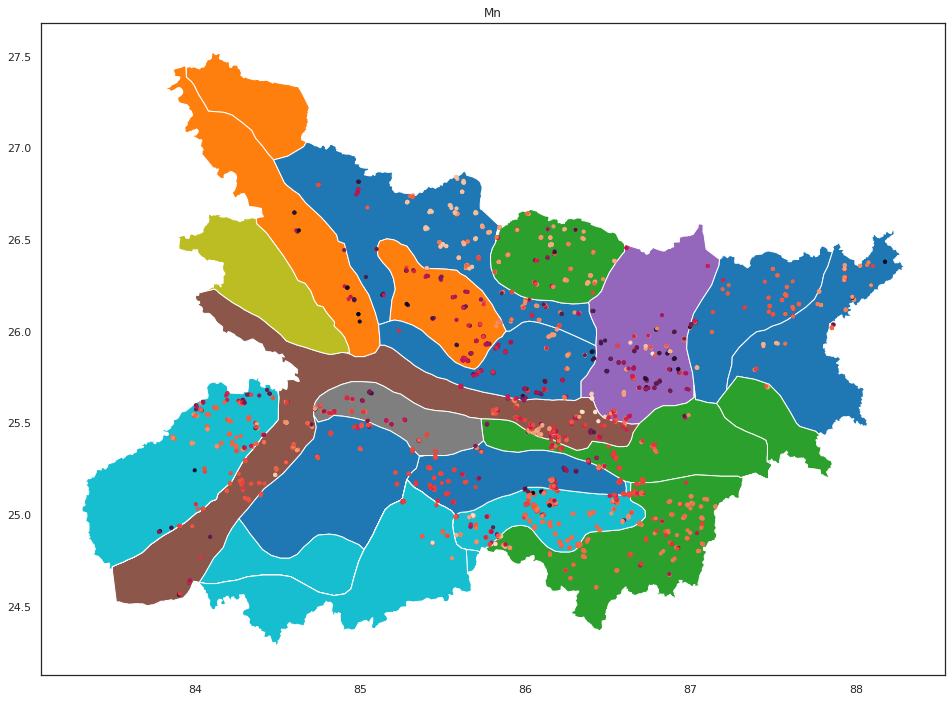

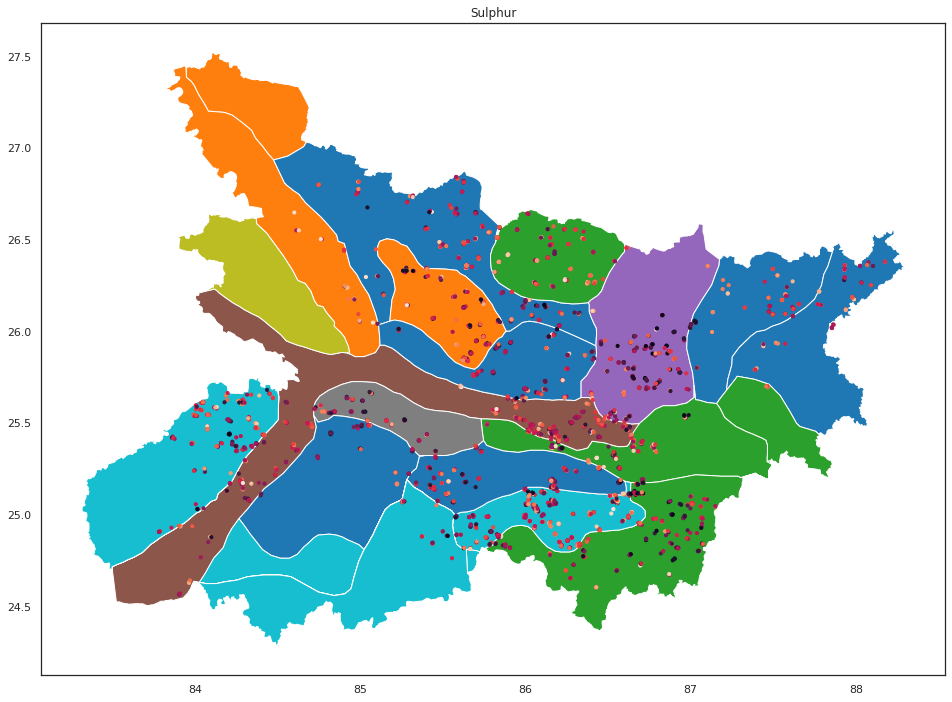

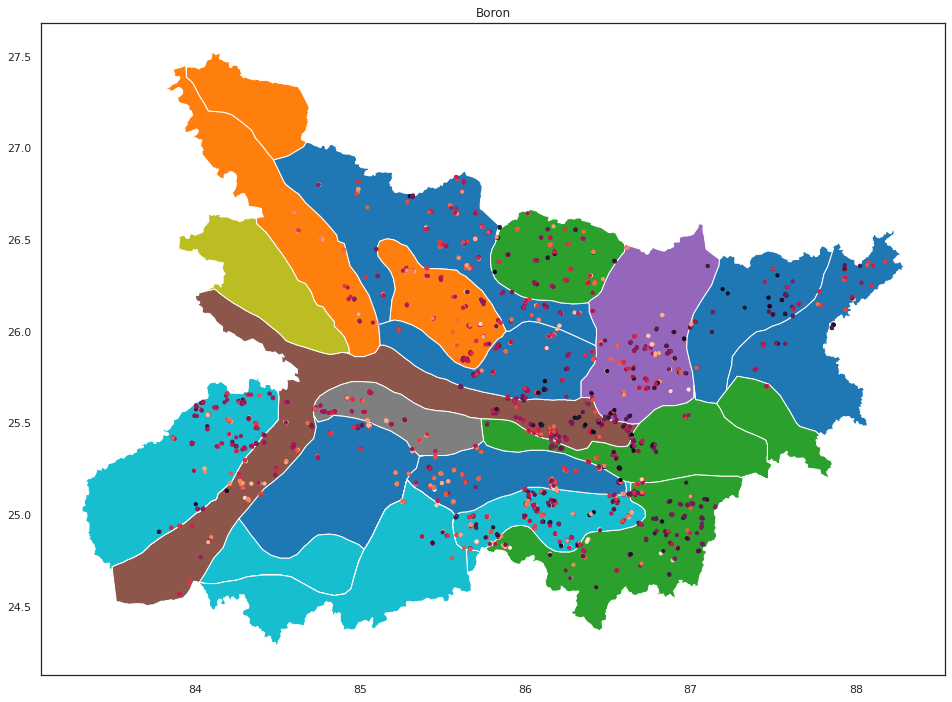

In [ ]:
# there is some structure in the above plot - samples labeled as same soil type land close in the embedding space.
# But what if the regions were arbitrarly selected? - color samples on map by 

embedded_with_metadata

wcdf
wc_location = sample_points_gdf.join(wcdf)

for element in wcdf:
    ax = soil_types_gdf.plot(soil_types_gdf["soil_type"], figsize=(20, 12))
    wc_location_no_outliers_for_analyte = drop_outliers_col(wc_location, element)
    wc_location_no_outliers_for_analyte.plot(ax=ax, marker='o', 
                                             c=wc_location_no_outliers_for_analyte[element],
                                             markersize=10)
    ax.set_title(element)


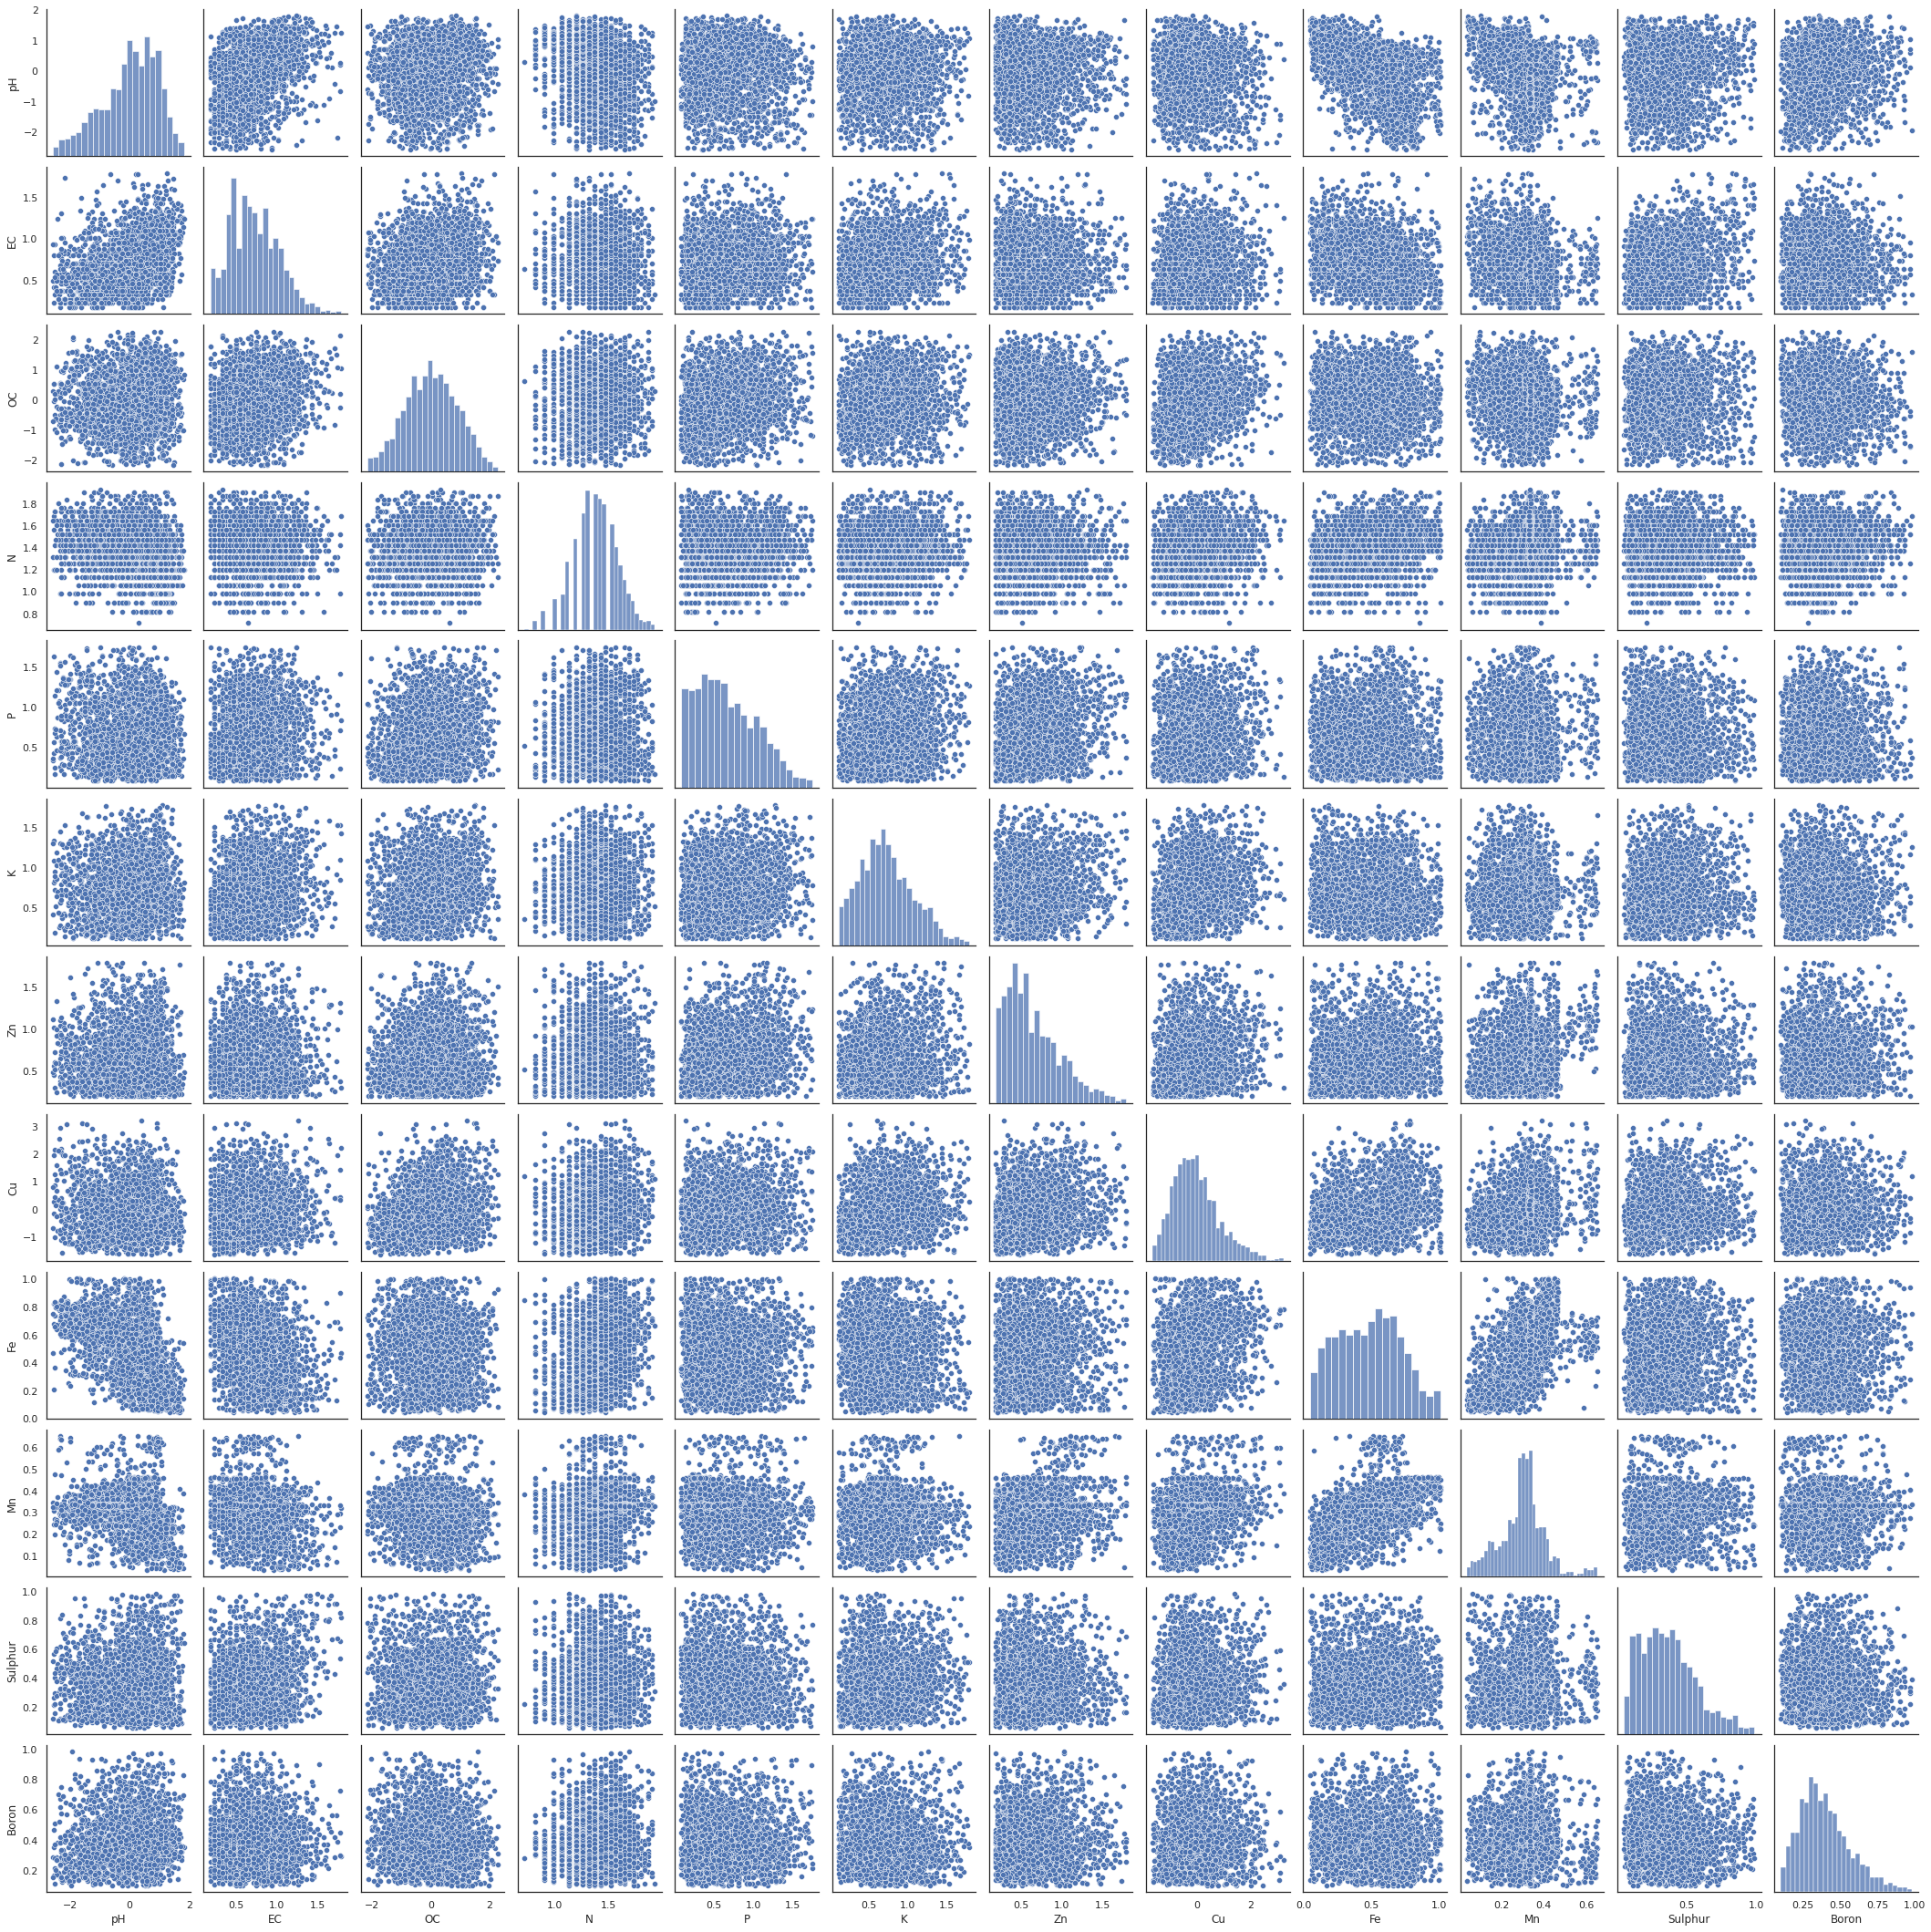

In [ ]:
sns.pairplot(wcdf)


some anomalies:
1. Nitrogen values are quantized 
2. Mangan values are cut off at a certain level above which the distribution changes


In [ ]:


# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=bool))

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))

# # Generate a custom diverging colormap

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt=".2f")

<AxesSubplot:>

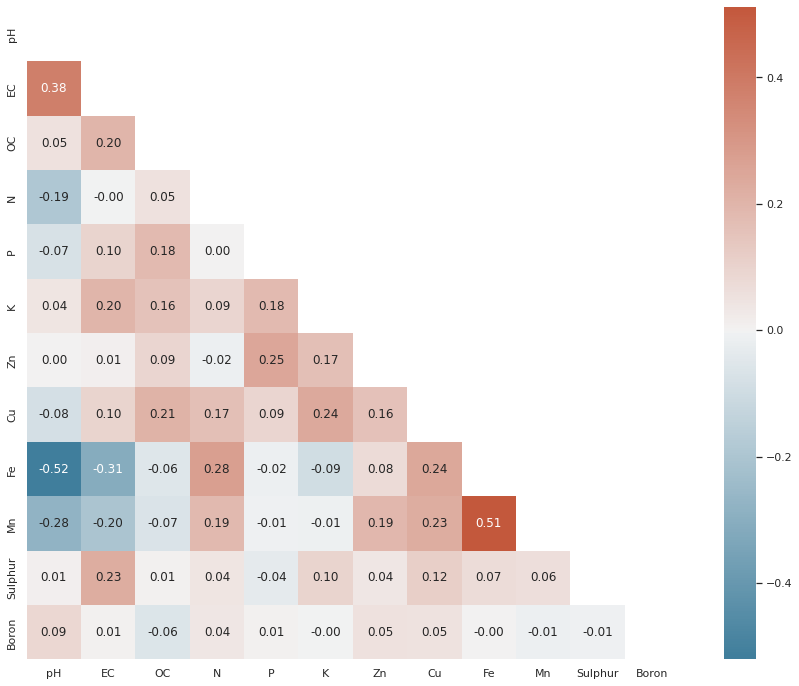

In [ ]:
corr = wcdf.corr()

plt.figure(figsize=(16,12))
sns.set_theme(style="white")

cmap = sns.diverging_palette(230, 20, as_cmap=True)

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap)

In [ ]:


skew(wcdf)


array([-0.54465863,  2.86346403,  0.12236915,  0.55208864,  1.67608543,
        2.15091735,  2.53498253,  1.17529597,  0.61170069,  2.79070875,
        3.74623713,  4.66700754])

dropped 192 rows
dropped 195 rows


<AxesSubplot:xlabel='Sulphur', ylabel='Count'>

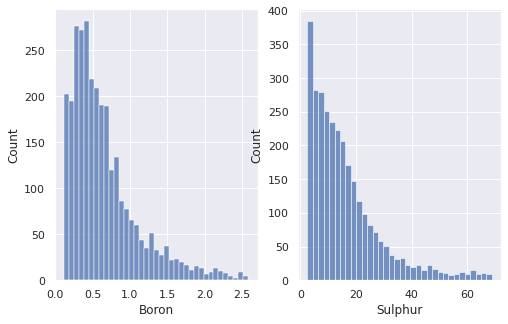

In [ ]:
boron = drop_outliers(wcdf_raw["Boron"])
skew(np.log(1 + boron))
def unskew1(x, eps=1e-5):
    x = x - min(x)
    return np.log(eps + x)


def unskew2(x):
    x = x - min(x)
    return (1 + x) ** (1/2)


f, axes = plt.subplots(1, 2, figsize=(8,5))
sns.histplot(boron, ax=axes[0])
sns.histplot(drop_outliers(wcdf_raw["Sulphur"]), ax=axes[1])



/home/bart2/.pyenv/versions/3.9.5/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0, 0.5, 'amount')

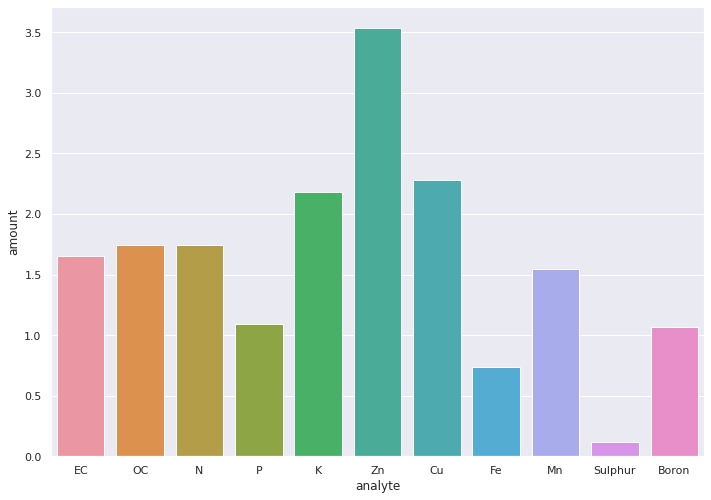

In [16]:
# sns.barplot(wcdf_raw.iloc[0])
data = wcdf_norm.iloc[0, 1:] + 1.6
ax = sns.barplot(data.index, data.values)
ax.set_xlabel("analyte")
ax.set_ylabel("amount")